# 2D tracking

In this notebook, we demonstrate the multidimensional filtering on a simple tracking model

$$
\begin{equation}
    \begin{split}
        \mathrm{d}
        \begin{bmatrix}
            X_1(t) \\ X_2(t)
        \end{bmatrix} &=
        \begin{bmatrix}
            0 & 1 \\
            0 & 0
        \end{bmatrix} \,
        \begin{bmatrix}
            X_1(t) \\ X_2(t)
        \end{bmatrix} \mathrm{d}t + B \mathrm{d}W(t), \\
        Y_k &= \arctan(X_2(t_k)/X_1(t_k)) + \xi_k,
    \end{split}
\end{equation}
$$

where $X$ starts from a Gaussian mixture initial distribution (see the code for detailed parameters), and $\xi_k \sim N(0, 0.1)$

In [335]:
import math
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mfs.multi_dims.multi_indices import generate_graded_lexico_multi_indices, gram_and_hankel_indices_graded_lexico
from mfs.multi_dims.filtering import moment_filter_nd_cms
from mfs.multi_dims.moments import raw_moments_mvn_kan
from mfs.utils import discretise_lti_sde, GaussianSumND
from jax.config import config
from functools import partial

config.update("jax_enable_x64", True)

key = jax.random.PRNGKey(999)

# Multi-indices
The annoying part of multidimensional moments is that we have to play with multi-indices.

Well, I have implemented this part, so just input the state dimension $d$ and the moment order $N$, then call `generate_graded_lexico_multi_indices` and `gram_and_hankel_indices_graded_lexico` to get graded lexicographical ordered moments.

In [336]:
# Dimension and order
d = 2
N = 4

# Multi-indices
multi_indices = generate_graded_lexico_multi_indices(d, 2 * N - 1, 0)

# These are indices to generate the Gram and Hankel matrices
inds = gram_and_hankel_indices_graded_lexico(N, d)

# Define the model

Now we define the model and simulation details.

In [337]:
# Times
dt = 0.01
T = 100
ts = jnp.linspace(dt, dt * T, T)

# SDE coefficients
A = jnp.array([[0., 1.],
               [0., 0.]])
B = jnp.array([[0., 0.],
               [0., 1.]])

# We can discretise the SDE analytically
F, Q = discretise_lti_sde(A, B, dt)
chol_Q = jnp.linalg.cholesky(Q)

# The initial condition which is a Gaussian sum here.
means = jnp.array([[1., 0.],
                   [1., 1.]])
covs = jnp.array([[[1., 0.],
                   [0., 1.]],
                  [[1., 0.],
                   [0., 1.]]]) * 0.01
weights = jnp.array([0.7, 0.3])
init_cond = GaussianSumND.new(means, covs, weights, multi_indices)

# Measurement noise variance
xi = 0.1


# Simulate a trajectory and measurements
def simulate(_key):
    def scan_body(carry, elem):
        x = carry
        rnd_x, rnd_y = elem

        x = F @ x + chol_Q @ rnd_x
        y = jnp.arctan2(x[1], x[0]) + math.sqrt(xi) * rnd_y
        return x, (x, y)

    key_x0, key_xs, key_ys = jax.random.split(_key, 3)
    x0 = init_cond.sampler(key_x0, 1)[0]
    rnds_x = jax.random.normal(key_xs, (T, 2))
    rnds_y = jax.random.normal(key_ys, (T,))
    return jax.lax.scan(scan_body, x0, (rnds_x, rnds_y))[1]


xs, ys = simulate(key)

# Create the moment filter

In [338]:
@partial(jax.vmap, in_axes=[0, None, None])
@partial(jax.vmap, in_axes=[None, 0, None])
def state_cond_central_moments(x, index, mean):
    """Compute conditional central moments
    """
    cond_mean, cond_cov = F @ x, Q
    cms = jnp.asarray(
        [raw_moments_mvn_kan(cond_mean - mean, cond_cov, multi_index) for multi_index in multi_indices])
    return cms[index]


@partial(jax.vmap, in_axes=[0])
def state_cond_mean(x):
    """Compute conditional mean
    """
    return F @ x


def measurement_cond_pdf(y, x):
    """p(y | x)
    """
    return jax.scipy.stats.norm.pdf(y, jnp.arctan2(x[1], x[0]), math.sqrt(xi))


# The moment filter using central moments
@jax.jit
def moment_filter(_ys):
    return moment_filter_nd_cms((state_cond_central_moments, 'index'), state_cond_mean, measurement_cond_pdf, _ys,
                                (jnp.asarray(multi_indices), inds), init_cond.cms, init_cond.mean)

In [339]:
# Do filtering!
cmss, means, nell = moment_filter(ys)

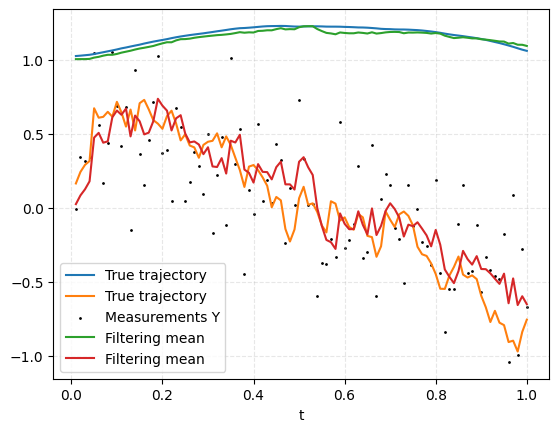

In [343]:
# Plot
plt.plot(ts, xs, label='True trajectory')
plt.scatter(ts, ys, c='black', s=1, label='Measurements Y')
plt.plot(ts, means, label='Filtering mean')
_ = plt.legend()
plt.grid(linestyle='--', alpha=0.3, which='both')
_ = plt.xlabel('t')